# Resolution functions
The purpose of the resolution function is to enable the `EasyReflectometry` model to quantify the experimental uncertainties in wavelength and incident angle.
When determining reflectivity the resolution function defines the smearing to apply.  For a given Q-point such smearing is applied by determining an average of the neighboring Q-point weigthed by a normal distribution, which has a Q-point dependent Full Width at the Half Maximum (FWHM) that again is defined by the resolution function.

Often we rely on a resolution function that has a simple functional dependecy of the Q-point.  By this is understood that the applied smearing in an Q point-has a FWHM that is given as a percentage of the value of the Q-point.

Alternatively the FWHM value might be determined and declared directly for each measured Q-point.
When this is the case the provided Q-points and the corresponding FWHM values can be used to declare a linear spline function and thereby enable a determination of the reflectivity at an arbitrary point within the provided range of discrete Q-points.

## Setup
First configure matplotlib to place figures in notebook and import needed modules

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import scipp as sc


import EasyReflectometry
import refnx

from EasyReflectometry.calculators import CalculatorFactory
from EasyReflectometry.data import load
from EasyReflectometry.experiment import Model
from EasyReflectometry.experiment import percentage_fhwm_resolution_function
from EasyReflectometry.experiment import linear_spline_resolution_function
from EasyReflectometry.sample import Layer
from EasyReflectometry.sample import Material
from EasyReflectometry.sample import Multilayer
from EasyReflectometry.sample import Sample
from EasyReflectometry.plot import plot

For reference we fetch the version of the software packages we are using. 

In [2]:
print(f'numpy: {np.__version__}')
print(f'scipp: {sc.__version__}')
print(f'EasyReflectometry: {EasyReflectometry.__version__}')
print(f'Refl1D: {refnx.__version__}')

numpy: 1.26.4
scipp: 24.02.0
EasyReflectometry: 0.0.0
Refl1D: 0.1.45


## Reading in measured data

The data that we will investigate in this tutorial was generated with `Refnx` and are stored in `.ort` [format file](https://github.com/reflectivity/file_format/blob/master/specification.md) files. In this tutorial we are investigation how we can include resolution effects when simulating and reproducing data measured in an experiment.  For an `.ort` file the resoultion data for reflectivity is stored in the fourth column.

IMPORTANT when using `EasyReflectometry` functionality for loading an `.ort` file we store the resolution data as a variance (squared value).  As a consequence one needs to take the squareroot of the loaded data to recover the raw values (fourth column).

In [3]:
dict_reference = {}
dict_reference['0'] = load("_static/resolution/mod_pointwise_two_layer_sample_dq-0.0.ort")
dict_reference['1'] = load("_static/resolution/mod_pointwise_two_layer_sample_dq-1.0.ort")
dict_reference['10'] = load('_static/resolution/mod_pointwise_two_layer_sample_dq-10.0.ort')

As an example we can plot the reference data without any resolution effects.

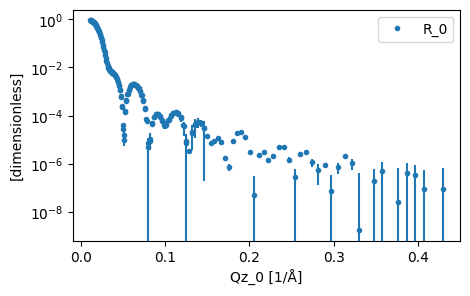

In [4]:
plot(dict_reference['0'])

## Building our model

The system that was used to produce the data shown above is based on a silicon subphase with two layers upon it. 
These two layers are charachterized by having a scattering length density (SLD) of respectively 4 and 8.
Both layers have a rougness of 2 but their thicknesses are 100 and 150 angstrom respectively.
We show the model that will be used graphically below. 

<center>
    <img src='_static/two_layers.png' alt='A slab model description of the two_layers system.' width='300px'></img>
</center>
<center>
    A slab model description of the two layer.
</center>

To construct such a layer structure, first we create each of the materials, the associated layers, and the sub and super phases. 

In [5]:
sld_4 = Material(sld=4.0, isld=0, name='Sld 4')
sld_8 = Material(sld=8.0, isld=0, name='Sld 8')
vacuum = Material(sld=0, isld=0, name='Vacuum')
si = Material(sld=2.047, isld=0, name='Si')

In [6]:
sld_4_layer = Layer(material=sld_4, thickness=100, roughness=2, name='SLD 4 Layer')
sld_8_layer = Layer(material=sld_8, thickness=150, roughness=2, name='SLD 8 Layer')
superphase = Layer(material=vacuum, thickness=0, roughness=0, name='Vacuum Superphase')
subphase = Layer(material=si, thickness=0, roughness=2, name='Si Subphase')

Then, to produce the two layered structure, we use the `Multilayer` [assembly type](../sample/assemblies_library.rst#Multilayer).

In [7]:
two_layers = Multilayer([sld_4_layer, sld_8_layer], name='SLD 4/8 Layer')
two_layers

SLD 4/8 Layer:
  SLD 4 Layer/SLD 8 Layer:
  - SLD 4 Layer:
      material:
        Sld 4:
          sld: 4.000e-6 1 / angstrom ** 2
          isld: 0.000e-6 1 / angstrom ** 2
      thickness: 100.000 angstrom
      roughness: 2.000 angstrom
  - SLD 8 Layer:
      material:
        Sld 8:
          sld: 8.000e-6 1 / angstrom ** 2
          isld: 0.000e-6 1 / angstrom ** 2
      thickness: 150.000 angstrom
      roughness: 2.000 angstrom

From this, we can construct our structure and combine this with a scaling and background.

In [8]:
sample = Sample(superphase, two_layers, subphase, name='Two Layer Sample')
model = Model(
    sample=sample,
    scale=1,
    background=0,
    name='Two Layer Model',
)

## Set the calculation engine

We will use the default [Refnx](https://refnx.readthedocs.io/) calculator for our analysis. 

In [9]:
interface = CalculatorFactory()
model.interface = interface
print(interface.current_interface.name)

refnx


## Resolution functions

We now define the different resoultion functions.  

In [10]:
resolution_function_dict = {}
resolution_function_dict['0'] = linear_spline_resolution_function(
    q_data_points=dict_reference['0']['coords']['Qz_0'].values,
    fwhm_values=np.sqrt(dict_reference['0']['coords']['Qz_0'].variances),
)

resolution_function_dict['1'] = linear_spline_resolution_function(
    q_data_points=dict_reference['1']['coords']['Qz_0'].values,
    fwhm_values=np.sqrt(dict_reference['1']['coords']['Qz_0'].variances),
)

resolution_function_dict['10'] = linear_spline_resolution_function(
    q_data_points=dict_reference['10']['coords']['Qz_0'].values,
    fwhm_values=np.sqrt(dict_reference['10']['coords']['Qz_0'].variances),
)

## Simulations
The next step is to visualise how the resolution functions affect the model.  
Furthermore, we compare the here determined reflectivities (Resolution) and the ones that were determined in `Refnx` (Reference).

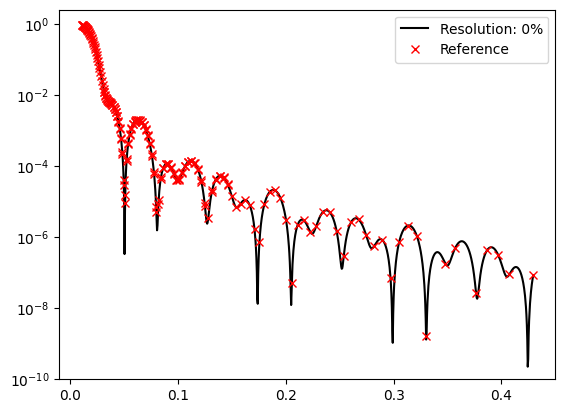

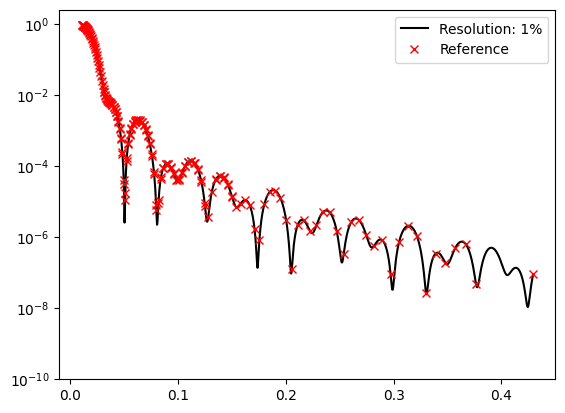

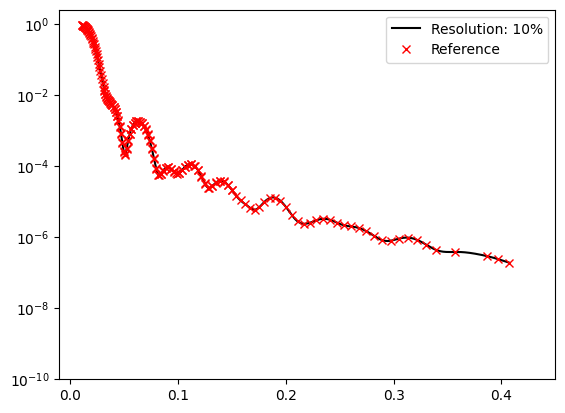

In [11]:
for key in resolution_function_dict.keys():
    reference_coords = dict_reference[key]['coords']['Qz_0'].values
    reference_data = dict_reference[key]['data']['R_0'].values
    model_coords = np.linspace(
        start=min(reference_coords),
        stop=max(reference_coords),
        num=1000,
    )
    model.resolution_function = resolution_function_dict[key]
    model_data = model.interface().fit_func(
        model_coords,
        model.uid,
    )
    plt.plot(model_coords, model_data, 'k-', label=f'Resolution: {key}%')
    plt.plot(reference_coords, reference_data, 'rx', label=f'Reference')
    ax = plt.gca()
    ax.set_xlim([-0.01, 0.45])
    ax.set_ylim([1e-10, 2.5])
    plt.legend()
    plt.yscale('log')
    plt.show()

From the plots it is apparent that an increasing resolution flattens the reflectivity profile.

## Afterthoughts
As a last task we will compare the reflectivity determined using a percentage resolution function and a point-wise function.
We should recall that the "experimental" data was generated using `Refnx`.
By comparing the reflectivities determined using a resolution function with a FWHM of 1.0% and the point-wise FHWN constructed from data in a `.ort` file it is apparent that this reference data also was constructed using a resolution function of 1.0%.

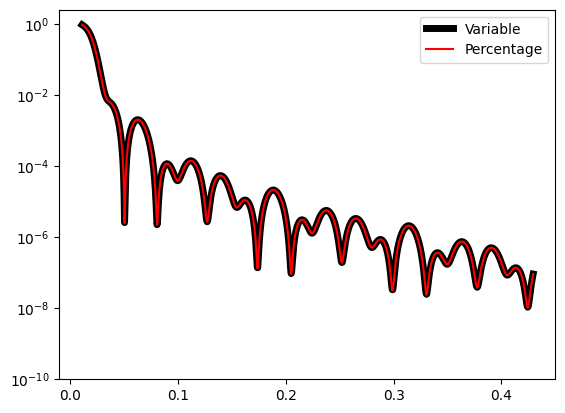

In [12]:
key = '1'
reference_coords = dict_reference[key]['coords']['Qz_0'].values
reference_data = dict_reference[key]['data']['R_0'].values
model_coords = np.linspace(
    start=min(reference_coords),
    stop=max(reference_coords),
    num=1000,
)

model.resolution_function = resolution_function_dict[key]
model_data = model.interface().fit_func(
    model_coords,
    model.uid,
)
plt.plot(model_coords, model_data, 'k-', label=f'Variable', linewidth=5)

model.resolution_function = percentage_fhwm_resolution_function(1.0)
model_data = model.interface().fit_func(
    model_coords,
    model.uid,
)
plt.plot(model_coords, model_data, 'r-', label=f'Percentage')

ax = plt.gca()
ax.set_xlim([-0.01, 0.45])
ax.set_ylim([1e-10, 2.5])
plt.legend()
plt.yscale('log')
plt.show()